# Breast Cancer Histopathology Classification with Train/Validation/Test Splits

This notebook includes:
- Preprocessing: splitting into **train**, **validation**, and **test** sets
- Data augmentation and generators
- Model architecture
- Training with plotted metrics
- Evaluation on **validation** and **test** sets
- Comprehensive markdown descriptions for each step
- Testing on example images

## 1. Preprocessing and Data Splitting

We split the dataset into three subsets:
- **Train**: for learning (60%)
- **Validation**: for tuning (20%)
- **Test**: for final evaluation (20%)

We use `train_test_split` twice to achieve this.

In [1]:

import os
import shutil
from sklearn.model_selection import train_test_split

# Define directories
dataset_dir = r"C:\Users\NITIN SINGH\Downloads\BreaKHis_v1\BreaKHis_v1\histology_slides\breast"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

# Create directories
for d in [train_dir, validation_dir, test_dir]:
    os.makedirs(os.path.join(d, "benign"), exist_ok=True)
    os.makedirs(os.path.join(d, "malignant"), exist_ok=True)

def split_three_ways(image_paths, train_frac=0.6, val_frac=0.2, test_frac=0.2, random_state=42):
    # First split off train and temp (val+test)
    train_paths, temp_paths = train_test_split(image_paths, test_size=1-train_frac, random_state=random_state)
    # Then split temp into validation and test
    val_relative = val_frac / (val_frac + test_frac)
    val_paths, test_paths = train_test_split(temp_paths, test_size=1-val_relative, random_state=random_state)
    return train_paths, val_paths, test_paths

def collect_and_store(source_dir, class_label):
    image_paths = [os.path.join(root, f) for root, _, files in os.walk(source_dir) 
                   for f in files if f.endswith(".png")]
    train_paths, val_paths, test_paths = split_three_ways(image_paths)
    # Copy files
    for paths, target_base in [(train_paths, train_dir), (val_paths, validation_dir), (test_paths, test_dir)]:
        for p in paths:
            shutil.copy(p, os.path.join(target_base, class_label, os.path.basename(p)))

# Execute for both classes
collect_and_store(os.path.join(dataset_dir, "benign"), "benign")
collect_and_store(os.path.join(dataset_dir, "malignant"), "malignant")

print("Dataset split into train, validation, and test sets!")

Dataset split into train, validation, and test sets!


## 2. Data Augmentation and Generators

We apply augmentation only to the training set and rescale all images by 1/255.

In [2]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    rotation_range=20
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode="binary"
)
validation_generator = val_test_datagen.flow_from_directory(
    validation_dir, target_size=(224,224), batch_size=32, class_mode="binary"
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32, class_mode="binary", shuffle=False
)

Found 6327 images belonging to 2 classes.
Found 2383 images belonging to 2 classes.
Found 1582 images belonging to 2 classes.


## 3. Model Architecture

A simple CNN with three convolutional blocks, followed by a dense layer and dropout.

In [3]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\NITIN SINGH\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training and Validation

We train for 10 epochs and plot accuracy and loss on both train and validation sets.

C:\Users\NITIN SINGH\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.7094 - loss: 0.7584 - val_accuracy: 0.8384 - val_loss: 0.4725
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8156 - loss: 0.4651 - val_accuracy: 0.8439 - val_loss: 0.4256
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8389 - loss: 0.4433 - val_accuracy: 0.8477 - val_loss: 0.3907
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8142 - loss: 0.4646 - val_accuracy: 0.8313 - val_loss: 0.4203
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.8400 - loss: 0.4242 - val_accuracy: 0.8552 - val_loss: 0.3749
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.8466 - loss: 0.4221 - val_accuracy: 0.8074 - val_loss: 0.4730
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8320 - loss: 0.4264 - val_accuracy: 0.8540 - val_loss: 0.3632
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.8428 - loss: 0.4066 - val_accu

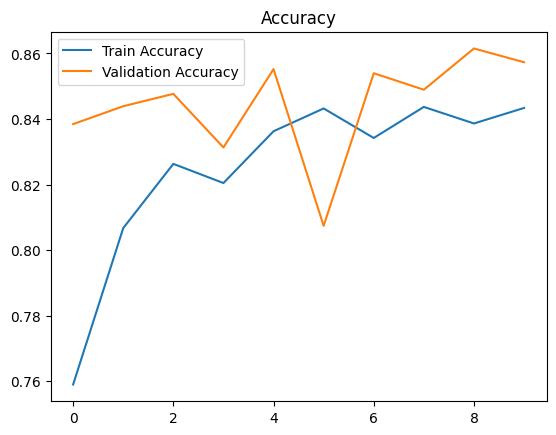

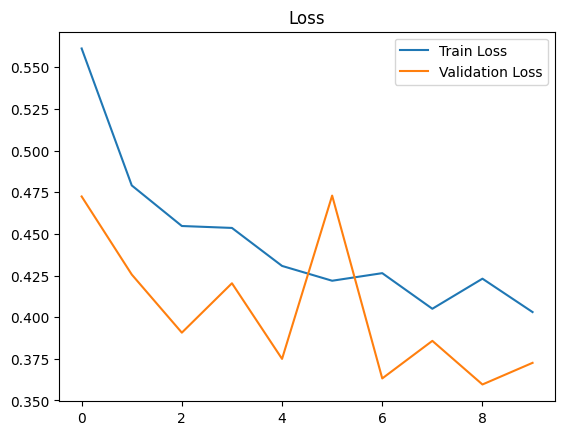

In [4]:

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Plot history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

## 5. Evaluation on Test Set

Finally, we evaluate the model on the **test** set, which was held out completely, to get an unbiased performance estimate.

In [5]:

# Evaluate and report on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Detailed metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob.ravel() > 0.5).astype(int)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign','Malignant']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8357 - loss: 0.4052
Test Loss: 0.3938, Test Accuracy: 0.8470
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.75      0.76      0.76       496
   Malignant       0.89      0.89      0.89      1086

    accuracy                           0.85      1582
   macro avg       0.82      0.82      0.82      1582
weighted avg       0.85      0.85      0.85      1582


Confusion Matrix:
[[378 118]
 [124 962]]


## 6. Save Model & Sample Predictions

Save the trained model, then run sample predictions on test images.

In [6]:

# Save the model
model.save("breast_cancer_classifier_with_test.h5")
print("Model saved as breast_cancer_classifier_with_test.h5")

# Sample predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
sample_paths = [os.path.join(test_dir, cls, fname) 
                for cls in ['benign','malignant'] 
                for fname in os.listdir(os.path.join(test_dir, cls))][:4]

for path in sample_paths:
    img = load_img(path, target_size=(224,224))
    arr = img_to_array(img)/255.0
    pred = model.predict(arr.reshape(1,224,224,3))[0][0]
    label = "Malignant" if pred>0.5 else "Benign"
    print(f"{os.path.basename(path)} -> {label}")

Model saved as breast_cancer_classifier_with_test.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
SOB_B_A-14-22549AB-100-009.png -> Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
SOB_B_A-14-22549AB-100-030.png -> Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
SOB_B_A-14-22549AB-200-001.png -> Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
SOB_B_A-14-22549AB-200-003.png -> Benign
